In [208]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [209]:
# Define paths
dataset_dir = 'color'
train_dir = 'color_split/train'
val_dir = 'color_split/validation'
test_dir = 'color_split/test'

In [3]:
#split data into test 0.8, validate 0.1, test 0.1
import os
import shutil
import numpy as np
from sklearn.model_selection import train_test_split


# Create directories
os.makedirs(train_dir, exist_ok=True)
os.makedirs(val_dir, exist_ok=True)
os.makedirs(test_dir, exist_ok=True)

# Create subdirectories for each class
classes = os.listdir(dataset_dir)
for class_name in classes:
    os.makedirs(os.path.join(train_dir, class_name), exist_ok=True)
    os.makedirs(os.path.join(val_dir, class_name), exist_ok=True)
    os.makedirs(os.path.join(test_dir, class_name), exist_ok=True)

# Split data
for class_name in classes:
    class_dir = os.path.join(dataset_dir, class_name)
    images = os.listdir(class_dir)
    
    # Split into training and remaining (test + validation)
    train_images, remaining_images = train_test_split(images, test_size=0.4, random_state=42)
    
    # Split remaining into validation and test
    val_images, test_images = train_test_split(remaining_images, test_size=0.5, random_state=42)
    
    # Move images to respective directories
    for image in train_images:
        shutil.move(os.path.join(class_dir, image), os.path.join(train_dir, class_name, image))
    
    for image in val_images:
        shutil.move(os.path.join(class_dir, image), os.path.join(val_dir, class_name, image))
    
    for image in test_images:
        shutil.move(os.path.join(class_dir, image), os.path.join(test_dir, class_name, image))


In [210]:
#Load data with ImageGenerator
# Set up data generators

batch_size = 8

# Data augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
)

train_generator = train_datagen.flow_from_directory(
    train_dir, 
    target_size=(224, 224), 
    batch_size=batch_size, 
    class_mode='categorical'
)

val_test_datagen = ImageDataGenerator(rescale=1./255)

validation_generator = val_test_datagen.flow_from_directory(
    val_dir, 
    target_size=(224, 224), 
    batch_size=batch_size, 
    class_mode='categorical'
)

test_generator =val_test_datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),
    batch_size=8,
    class_mode='categorical'
)

Found 160 images belonging to 5 classes.
Found 54 images belonging to 5 classes.
Found 56 images belonging to 5 classes.


In [211]:
print(f"Number of training samples: {train_generator.samples}")
print(f"Number of validation samples: {validation_generator.samples}")
print(f"Number of test samples: {test_generator.samples}")

Number of training samples: 160
Number of validation samples: 54
Number of test samples: 56


In [212]:
# Compute class weights
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_generator.classes),
    y=train_generator.classes
)

class_weights = dict(enumerate(class_weights))

In [220]:
from tensorflow.keras.regularizers import l2
from tensorflow.keras import regularizers
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.models import Model

num_classes = len(train_generator.class_indices)
print(num_classes)

# Load pre-trained MobileNetV2 model + higher level layers
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Define L2 regularization strength and dropout rate
l2_strength = 0.001 #(e.g., l2(0.001) or l2(0.005)
dropout_rate = 0.5 #(e.g., 0.3 or 0.7)

# Add custom layers on top
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu', kernel_regularizer=l2(l2_strength))(x)
x = Dropout(dropout_rate)(x)
predictions = Dense(num_classes, activation='softmax')(x)

# Define the model
model = Model(inputs=base_model.input, outputs=predictions)

# Freeze the base model layers
for layer in base_model.layers:
    layer.trainable = False



5


In [214]:
# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()

Model: "functional_25"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_27      │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 112, 112,  │        864 │ input_layer_27[0… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 112, 112,  │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 112, 112,  │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 112, 112,  │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 112, 112,  │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 112, 112,  │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 113, 113,  │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 56, 56,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 56, 56,    │      2,304 │ block_1_depthwis

 Total params: 3,574,853 (13.64 MB)

 Trainable params: 1,316,869 (5.02 MB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [215]:
print(f"Train steps per epoch: {train_generator.samples // train_generator.batch_size}")
print(f"Validation steps: {validation_generator.samples // validation_generator.batch_size}")


Train steps per epoch: 20
Validation steps: 6


In [216]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, LearningRateScheduler
import tensorflow as tf


# Callbacks
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3, min_lr=1e-6)
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

def scheduler(epoch, lr):
    if epoch < 10:
        return lr
    else:
        return float(lr * tf.math.exp(-0.1).numpy())

lr_scheduler = LearningRateScheduler(scheduler)

In [217]:
# Train the model with class weights
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // validation_generator.batch_size,
    epochs=100,
    class_weight=class_weights,
    callbacks = [reduce_lr]
)

Epoch 1/100


C:\Users\User\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


20/20 ━━━━━━━━━━━━━━━━━━━━ 8s 186ms/step - accuracy: 0.3224 - loss: 4.4838 - val_accuracy: 0.3958 - val_loss: 2.6003 - learning_rate: 0.0010
Epoch 2/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.3333 - val_loss: 3.4246 - learning_rate: 0.0010
Epoch 3/100


C:\Users\User\anaconda3\Lib\contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 84ms/step - accuracy: 0.4868 - loss: 3.1176 - val_accuracy: 0.3750 - val_loss: 3.5316 - learning_rate: 0.0010
Epoch 4/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.5000 - val_loss: 2.1885 - learning_rate: 0.0010
Epoch 5/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 85ms/step - accuracy: 0.4985 - loss: 2.3882 - val_accuracy: 0.6875 - val_loss: 1.7514 - learning_rate: 0.0010
Epoch 6/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 1.0000 - val_loss: 1.1047 - learning_rate: 0.0010
Epoch 7/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 85ms/step - accuracy: 0.5270 - loss: 1.8116 - val_accuracy: 0.7292 - val_loss: 1.6116 - learning_rate: 0.0010
Epoch 8/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 1.0000 - val_loss: 1.1185 - learning_rate: 0.0010
Epoch 9/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 85ms/step - accuracy: 0.6105 - loss: 

20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 83ms/step - accuracy: 0.8205 - loss: 1.1518 - val_accuracy: 0.7708 - val_loss: 1.3435 - learning_rate: 1.0000e-06
Epoch 88/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 1.0000 - val_loss: 0.8989 - learning_rate: 1.0000e-06
Epoch 89/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 85ms/step - accuracy: 0.7787 - loss: 1.3625 - val_accuracy: 0.7708 - val_loss: 1.3300 - learning_rate: 1.0000e-06
Epoch 90/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 1.0000 - val_loss: 1.0033 - learning_rate: 1.0000e-06
Epoch 91/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 84ms/step - accuracy: 0.7408 - loss: 1.2543 - val_accuracy: 0.7917 - val_loss: 1.3156 - learning_rate: 1.0000e-06
Epoch 92/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.8333 - val_loss: 1.1175 - learning_rate: 1.0000e-06
Epoch 93/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 85ms/st

In [218]:
# Evaluate the model on test data
test_loss, test_acc = model.evaluate(test_generator, steps=test_generator.samples // test_generator.batch_size)
print(f'Test accuracy: {test_acc}, Test loss: {test_loss}')

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.9365 - loss: 1.1824
Test accuracy: 0.9107142686843872, Test loss: 1.2347491979599


In [166]:
# Save the entire model to a file
model.save('color_model_final.h5')
model.save('color_model_final.keras')

In [203]:
from tensorflow.keras.models import load_model
# load previous model for fine tune
model = load_model('color_model_finetune4_layer25.h5')

In [204]:
# fine tuning

# Unfreeze some layers of the base model
for layer in base_model.layers[-25:]:
    layer.trainable = True
    
    
# Re-compile the model after unfreezing layers
model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

# Define callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-7)


# Continue training with fine-tuning
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // validation_generator.batch_size,
    epochs=200,
    class_weight=class_weights,
    callbacks = [reduce_lr, early_stopping]
)

Epoch 1/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 7s 139ms/step - accuracy: 0.7834 - loss: 0.9339 - val_accuracy: 0.7708 - val_loss: 0.9665 - learning_rate: 1.0000e-04
Epoch 2/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.6667 - val_loss: 2.1725 - learning_rate: 1.0000e-04
Epoch 3/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 85ms/step - accuracy: 0.7571 - loss: 0.8858 - val_accuracy: 0.7917 - val_loss: 0.8828 - learning_rate: 1.0000e-04
Epoch 4/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.5000 - val_loss: 2.7912 - learning_rate: 1.0000e-04
Epoch 5/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 84ms/step - accuracy: 0.7170 - loss: 0.8333 - val_accuracy: 0.7500 - val_loss: 1.0777 - learning_rate: 1.0000e-04
Epoch 6/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.8333 - val_loss: 1.2911 - learning_rate: 1.0000e-04
Epoch 7/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 

In [205]:
# Evaluate the model
test_loss, test_accuracy = model.evaluate(test_generator, steps=test_generator.samples // test_generator.batch_size)
print(f"Test accuracy: {test_accuracy}, Test loss: {test_loss}")

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - accuracy: 0.9415 - loss: 0.6715
Test accuracy: 0.9285714030265808, Test loss: 0.8965980410575867


In [206]:
# Save the entire model to a file
model.save('color_model_finetune5_layer25.h5')
model.save('color_model_finetune5_layer25.keras')

# Optionally, save only the model weights if you don't need to save the entire architecture
#model.save_weights('shape_weight_74acc.weights.h5')

# Inference

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 915ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━

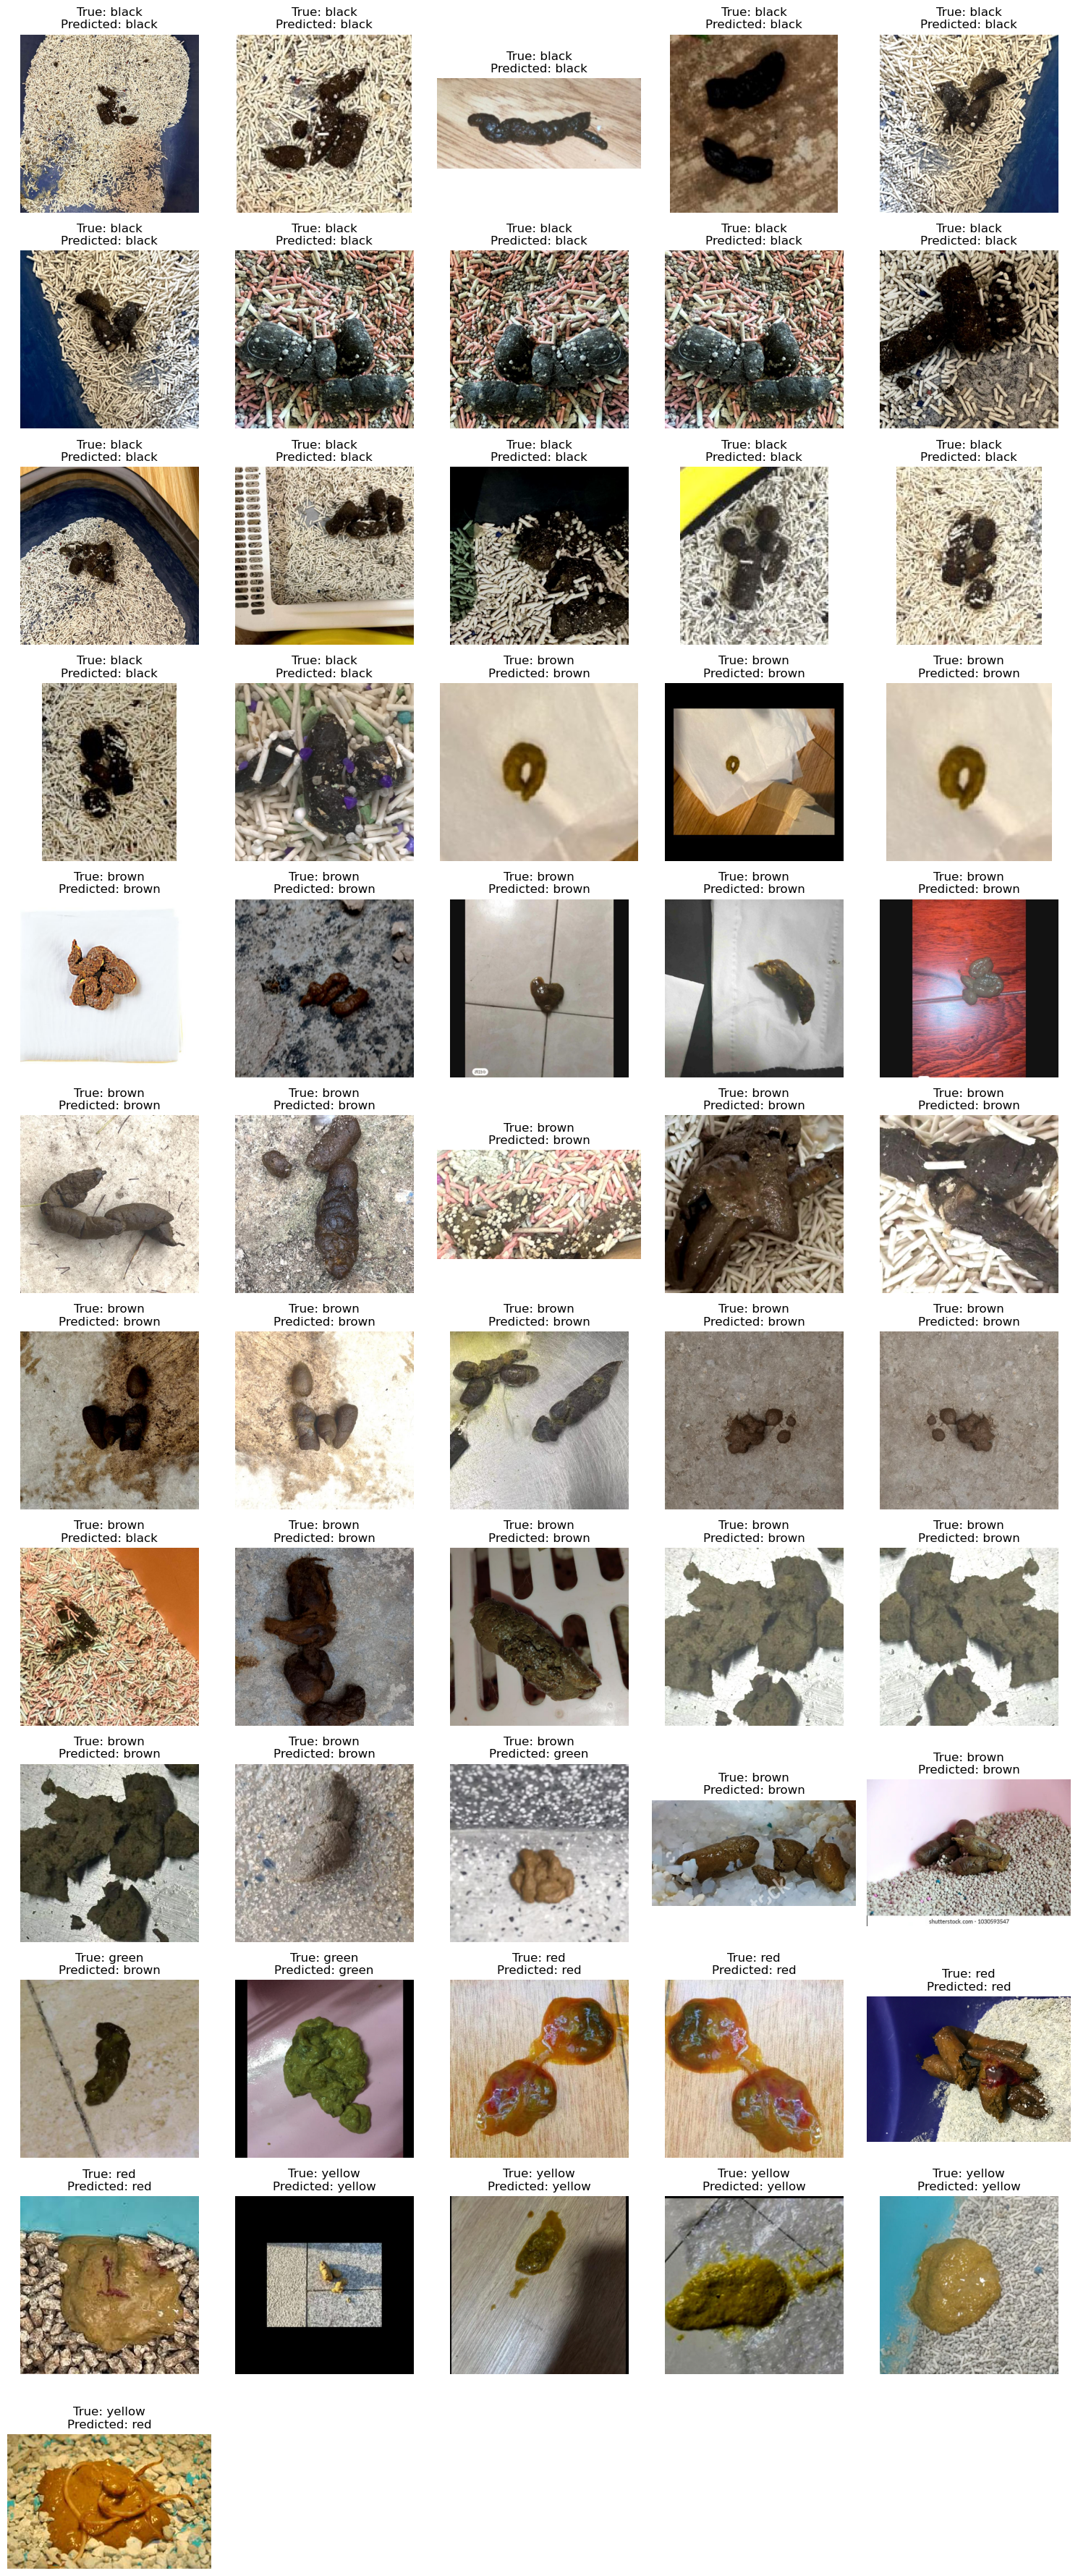

In [221]:
import numpy as np
import matplotlib.pyplot as plt
import os
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image

# Load your model
model = load_model('color_model_finetune5_layer25.h5')

# Function to preprocess the image
def preprocess_image(img_path, target_size):
    img = image.load_img(img_path, target_size=target_size)
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)  # Create a batch dimension
    img_array /= 255.0  # Normalize the image
    return img_array

# Function to collect images and predictions
def collect_images_and_predictions(test_dir, target_size, class_names):
    images = []
    true_labels = []
    predicted_labels = []
    
    for category in os.listdir(test_dir):
        category_path = os.path.join(test_dir, category)
        if os.path.isdir(category_path):
            for img_name in os.listdir(category_path):
                img_path = os.path.join(category_path, img_name)
                
                # Preprocess image
                img_array = preprocess_image(img_path, target_size)
                
                # Make predictions
                predictions = model.predict(img_array)
                predicted_index = np.argmax(predictions[0])
                predicted_label = class_names[predicted_index]  # Map index to class name
                
                images.append(img_path)
                true_labels.append(category)
                predicted_labels.append(predicted_label)
    
    return images, true_labels, predicted_labels

# Function to display images in a grid
def display_images_grid(images, true_labels, predicted_labels, num_per_row=5):
    num_images = len(images)
    num_rows = (num_images + num_per_row - 1) // num_per_row
    
    plt.figure(figsize=(15, num_rows * 3))
    
    for i in range(num_images):
        plt.subplot(num_rows, num_per_row, i + 1)
        img = image.load_img(images[i])
        plt.imshow(img)
        plt.title(f'True: {true_labels[i]}\nPredicted: {predicted_labels[i]}')
        plt.axis('off')
    
    plt.tight_layout()
    plt.show()
    
# Directory containing the test dataset
test_dir = 'color_split/test'
target_size = (224, 224)  # Use the size that your model expects

class_names = ['black', 'brown', 'green','red', 'yellow'] 

# Collect images and predictions
images, true_labels, predicted_labels = collect_images_and_predictions(test_dir, target_size, class_names)

# Display images in a grid
display_images_grid(images, true_labels, predicted_labels)